In [1]:
import pandas as pd
import numpy as np
import os
from obspy import read
from  matplotlib import pyplot as plt, dates 

import glob

# Explore data

In [2]:
data_path="../data/igf/"
data = pd.read_excel(data_path + "Catalog_20_21.xlsx", index_col=0)

In [3]:
data.head(5)

Datetime             X             Y  Depth        Mw   
0 2020-01-01 10:09:42.200  5.582503e+06  5.702646e+06    0.7  2.469231  \
1 2020-01-02 08:03:06.300  5.577930e+06  5.705644e+06    0.7  1.916667   
2 2020-01-03 14:36:51.500  5.582597e+06  5.701562e+06    0.7  1.916667   
3 2020-01-04 05:01:01.700  5.575319e+06  5.716387e+06    0.7  1.600000   
4 2020-01-04 14:52:08.100  5.577217e+06  5.705684e+06    0.7  1.844444   

                                              Phases            mseed_name  
0  Pg BRDW 2020-01-01 10:09:44.400, Sg BRDW 2020-...  20200101100941.mseed  
1  Pg BRDW 2020-01-02 08:03:07.118, Sg BRDW 2020-...  20200102080305.mseed  
2  Pg DWOL 2020-01-03 14:36:54.525, Sg DWOL 2020-...  20200103143651.mseed  
3  Pg DWOL 2020-01-04 05:01:03.089, Sg DWOL 2020-...  20200104050102.mseed  
4  Pg BRDW 2020-01-04 14:52:08.488, Sg BRDW 2020-...  20200104145207.mseed

In [4]:
data.shape

(2198, 7)

In [5]:
data.Datetime.unique()

<DatetimeArray>
['2020-01-01 10:09:42.200000', '2020-01-02 08:03:06.300000',
 '2020-01-03 14:36:51.500000', '2020-01-04 05:01:01.700000',
 '2020-01-04 14:52:08.100000',        '2020-01-04 19:47:26',
 '2020-01-05 06:27:21.300000',        '2020-01-05 10:42:54',
 '2020-01-05 20:56:35.700000', '2020-01-06 05:35:10.100000',
 ...
 '2021-10-29 22:13:28.200000', '2021-10-30 09:01:58.100000',
 '2021-10-30 10:55:19.100000', '2021-10-30 20:49:21.200000',
 '2021-10-30 21:01:09.800000', '2021-10-30 22:12:27.100000',
 '2021-10-31 00:03:17.800000', '2021-10-31 01:13:04.100000',
 '2021-10-31 18:12:38.700000', '2021-10-31 19:11:48.200000']
Length: 2198, dtype: datetime64[ns]

In [6]:
data.dropna().shape

(1720, 7)

## Check missing data

#### Missing mseed_name

In [7]:
data[(data.mseed_name.isna())]

Datetime             X             Y     Depth        Mw   
11   2020-01-06 18:46:05.900  5.583057e+06  5.701401e+06  0.700000  1.880000  \
14   2020-01-07 19:24:16.900  5.583143e+06  5.701039e+06  0.700000  1.820000   
31   2020-01-14 03:58:31.700  5.582596e+06  5.701750e+06  0.700000  1.850000   
36   2020-01-15 09:01:16.700  5.582595e+06  5.703723e+06  0.800000  2.071429   
38   2020-01-16 04:55:53.600  5.576011e+06  5.706832e+06  0.700000  1.640000   
...                      ...           ...           ...       ...       ...   
2166 2021-10-25 00:30:29.400  5.574834e+06  5.706510e+06  0.700000  1.600000   
2173 2021-10-26 08:05:39.300  5.575470e+06  5.715877e+06  0.900000  1.366667   
2184 2021-10-28 15:15:41.600  5.575855e+06  5.715674e+06  0.900000  1.300000   
2186 2021-10-28 23:28:26.400  5.577772e+06  5.707358e+06  0.500000  1.400000   
2193 2021-10-30 22:12:27.100  5.580585e+06  5.713451e+06  0.919473  1.483333   

                                                 Phases mseed_name  
11    Pg GROD 2020-01-06 18:46:08.904, Sg GROD 2020-...        NaN  
14    Pg JEDR 2020-01-07 19:24:19.289, Sg JEDR 2020-...        NaN  
31    Pg JEDR 2020-01-14 03:58:33.990, Sg JEDR 2020-...        NaN  
36    Pg GROD 2020-01-15 09:01:19.262, Sg GROD 2020-...        NaN  
38    Pg MOSK2 2020-01-16 04:55:55.566, Sg MOSK2 202...        NaN  
...                                                 ...        ...  
2166  Pg BRDW 2021-10-25 00:30:30.324, Sg BRDW 2021-...        NaN  
2173  Sg DWOL 2021-10-26 08:05:40.992, Pg DWOL 2021-...        NaN  
2184  Pg DWOL 2021-10-28 15:15:42.729, Sg DWOL 2021-...        NaN  
2186  Pg DABR 2021-10-28 23:28:28.434, Sg DABR 2021-...        NaN  
2193  Pg ZUKW2 2021-10-30 22:12:27.983, Sg ZUKW2 202...        NaN  

[478 rows x 7 columns]

In [8]:
print("Missing mseed fname in catalog: ", data[(data.mseed_name.isna())].shape[0])

Missing mseed fname in catalog:  478


In [9]:
def extract_data_from_catalog(fname): 
    targets, frames = [], []
    data = data = pd.read_excel(fname, index_col=0)
    for row in data: 
        _targets, _frames = extract_data_from_event(row.Phases, row.mseed_fname)
    targets.extend(_targets)
    frames.extend(_frames)
    return targets, frames


def extract_data_from_event(phases, mseed_fname): 
    pass

### Calculate stats

In [10]:
def calculate_stats(phases, mseed_fname, stats={}, path=data_path+"mseeds"): 
    
    phases = [ann.split(' ') for ann in phases.split(', ')]
    phases = pd.DataFrame(phases, columns = ['phase', 'station', 'date', 'hour'])
    phases.index = pd.DatetimeIndex(phases.date + ' ' + phases.hour, tz= "UTC")

    
    mseed_path = f"{path}/mseeds_2020/{mseed_fname}"
    if not os.path.exists(mseed_path): 
        mseed_path = f"{path}/mseeds_2021/{mseed_fname}"

    mseed_exisits = os.path.exists(mseed_path)

    missing_traces_count = 0 # phases.shape[0]/2
    missing_annotations_count = 0
    missing_traces = {}

    if mseed_exisits: 

        stream = read(mseed_path)
        traces_count = len(stream.traces)
        
        mseed_stations = set()
        
        for i, trace in enumerate(stream.traces): 
           
            station = trace.stats.station
            mseed_stations.add(station)
            station_annotations = phases[phases.station==station]
            p_timestamps = station_annotations[station_annotations.phase=='Pg'].index
            s_timestamps = station_annotations[station_annotations.phase=='Sg'].index


            if station not in stats: 
                stats[station] = {'p':0, 's':0}
            stats[station]['p'] += len(p_timestamps)
            stats[station]['s'] += len(s_timestamps)


        annotated_stations = set(phases.station.values)
        stations_with_missing_traces = annotated_stations - mseed_stations
        missing_traces_count = len(stations_with_missing_traces)
        
        stations_with_missing_annotations = mseed_stations - annotated_stations
        missing_annotations_count = len(stations_with_missing_annotations)
        
        missing_data = {
            mseed_path: {
                'stations_with_missing_traces': stations_with_missing_traces, 
                'stations_with_missing_annotations': stations_with_missing_annotations,
                'stations_with_available_data': mseed_stations.intersection(annotated_stations)
            }
        }

    return stats, mseed_exisits, missing_annotations_count, missing_traces_count, missing_data
    

In [11]:
stats = {}
missing_files = []
missing_traces = 0
missing_annotations = 0 
missing_data = {}

for phases, fname in zip(data.Phases, data.mseed_name): 
    
    if not pd.isna(fname): 
        stats, mseed_exisits, missing_annotations_, missing_traces_, missing_data_ = calculate_stats(phases, fname, stats)
        missing_annotations += missing_annotations_
        missing_traces += missing_traces_
        missing_data.update(missing_data_)
    if not mseed_exisits: 
        missing_files.append(fname)
        
stats = pd.DataFrame(stats)/3        
missing_data = pd.DataFrame(missing_data).transpose()

print("Stats")
print("Missing files: ", len(missing_files))
print("Missing annotations: ", missing_annotations)
print("Missing traces: ", missing_traces)
print("Missing mseed fname in catalog: ", data[(data.mseed_name.isna())].shape[0])

Stats
Missing files:  0
Missing annotations:  12286
Missing traces:  142
Missing mseed fname in catalog:  478


In [12]:
missing_data.stations_with_missing_traces = missing_data.stations_with_missing_traces.apply(lambda x: list(x) if len(x)>0 else None)
missing_data.stations_with_missing_annotations = missing_data.stations_with_missing_annotations.apply(lambda x: list(x) if len(x)>0 else None)
missing_data['path'] = missing_data.index
missing_data.index = missing_data.path.apply(lambda x: os.path.basename(x))

In [13]:
missing_data[~missing_data.stations_with_missing_traces.isna()].head()

stations_with_missing_traces   
path                                                
20200109224901.mseed                       [RYNR]  \
20200111165827.mseed                       [TRN2]   
20200112055037.mseed                       [TRZS]   
20200114011249.mseed                       [PCHB]   
20200123060736.mseed                       [GROD]   

                                      stations_with_missing_annotations   
path                                                                      
20200109224901.mseed  [RZEC, TRBC2, LUBW, TRZS, PPOL, OBIS, GROD, RU...  \
20200111165827.mseed        [RZEC, TRBC2, LUBW, TRZS, OBIS, RUDN, LUBZ]   
20200112055037.mseed  [RZEC, TRBC2, MOSK2, LUBW, BRDW, SGOR, GUZI, P...   
20200114011249.mseed  [RZEC, TRBC2, LUBW, DWOL, BRDW, TRZS, SGOR, GU...   
20200123060736.mseed        [RZEC, TRBC2, LUBW, BRDW, OBIS, PCHB, LUBZ]   

                                           stations_with_available_data   
path                                                                      
20200109224901.mseed  {MOSK2, JEDR, DWOL, BRDW, GUZI, NWLU, TRN2, PC...  \
20200111165827.mseed  {MOSK2, JEDR, DWOL, RYNR, BRDW, GUZI, NWLU, PP...   
20200112055037.mseed   {JEDR, DWOL, RYNR, NWLU, RUDN, TRN2, GROD, ZMST}   
20200114011249.mseed  {MOSK2, JEDR, RYNR, PPOL, RUDN, TRN2, GROD, ZMST}   
20200123060736.mseed  {MOSK2, JEDR, RYNR, TRZS, NWLU, GUZI, PPOL, RU...   

                                                                   path  
path                                                                     
20200109224901.mseed  ../data/igf/mseeds/mseeds_2020/20200109224901....  
20200111165827.mseed  ../data/igf/mseeds/mseeds_2020/20200111165827....  
20200112055037.mseed  ../data/igf/mseeds/mseeds_2020/20200112055037....  
20200114011249.mseed  ../data/igf/mseeds/mseeds_2020/20200114011249....  
20200123060736.mseed  ../data/igf/mseeds/mseeds_2020/20200123060736....

In [14]:
missing_data[~missing_data.stations_with_missing_annotations.isna()].head()

stations_with_missing_traces   
path                                                
20200101100941.mseed                         None  \
20200102080305.mseed                         None   
20200103143651.mseed                         None   
20200104050102.mseed                         None   
20200104145207.mseed                         None   

                                      stations_with_missing_annotations   
path                                                                      
20200101100941.mseed                                       [OBIS, LUBZ]  \
20200102080305.mseed  [RZEC, LUBW, RYNR, TRZS, SGOR, OBIS, TRN2, PCH...   
20200103143651.mseed  [RZEC, TRBC2, MOSK2, LUBW, BRDW, TRZS, SGOR, G...   
20200104050102.mseed  [RZEC, TRBC2, LUBW, JEDR, RYNR, BRDW, TRZS, NW...   
20200104145207.mseed  [RZEC, TRBC2, LUBW, TRZS, NWLU, OBIS, PCHB, GR...   

                                           stations_with_available_data   
path                                                                      
20200101100941.mseed  {RZEC, TRBC2, MOSK2, JEDR, RYNR, LUBW, BRDW, T...  \
20200102080305.mseed  {TRBC2, MOSK2, JEDR, BRDW, NWLU, GUZI, PPOL, Z...   
20200103143651.mseed               {JEDR, DWOL, RYNR, TRN2, GROD, RUDN}   
20200104050102.mseed              {MOSK2, DWOL, GUZI, GROD, ZMST, SGOR}   
20200104145207.mseed  {MOSK2, JEDR, DWOL, RYNR, BRDW, GUZI, PPOL, TR...   

                                                                   path  
path                                                                     
20200101100941.mseed  ../data/igf/mseeds/mseeds_2020/20200101100941....  
20200102080305.mseed  ../data/igf/mseeds/mseeds_2020/20200102080305....  
20200103143651.mseed  ../data/igf/mseeds/mseeds_2020/20200103143651....  
20200104050102.mseed  ../data/igf/mseeds/mseeds_2020/20200104050102....  
20200104145207.mseed  ../data/igf/mseeds/mseeds_2020/20200104145207....

### Inspect cases with missing annotations

In [15]:
fname = missing_data[~missing_data.stations_with_missing_annotations.isna()].index[0]
missing_stations = missing_data.loc[fname].stations_with_missing_annotations
print("Stations with missing annotations: ", missing_stations)
st = read(missing_data.loc[fname].path)
st

Stations with missing annotations:  ['OBIS', 'LUBZ']


57 Trace(s) in Stream:

PL.BRDW..EHE | 2020-01-01T10:09:36.480000Z - 2020-01-01T10:09:56.480000Z | 100.0 Hz, 2001 samples
...
(55 other traces)
...
PL.ZMST..EHZ | 2020-01-01T10:09:36.480000Z - 2020-01-01T10:09:56.480000Z | 100.0 Hz, 2001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [16]:
def plot_traces_from_mseed(phases, mseed_fname, path=data_path+"mseeds/mseeds_2020", channel=None): 

    phases = [ann.split(' ') for ann in phases.split(', ')]
    phases = pd.DataFrame(phases, columns = ['phase', 'station', 'date', 'hour'])
    phases.index = pd.DatetimeIndex(phases.date + ' ' + phases.hour, tz= "UTC")

    stream = read(f"{path}/{mseed_fname}")
    traces_count = len(stream.traces)
    if channel is not None: 
        traces_count = int(traces_count/3) 
        
    fig, axes = plt.subplots(traces_count, figsize=(20, traces_count*1.5))
    
    for i, trace in enumerate(stream.traces): 
        trace_series = pd.Series(trace.data)
        
        if channel is not None: 
            idx = int(i/3)
            if trace.stats.channel[-1]!=channel: 
                continue
        else: 
            idx = i
            
        freq = 1000 / trace.stats.sampling_rate
        trace_series.index = pd.date_range(start=str(trace.stats.starttime), end=str(trace.stats.endtime), freq=f'{freq}ms')

        trace_series.plot(title=f"{trace.stats.station} {trace.stats.channel}", ax=axes[idx])

        station = trace.stats.station
        station_annotations = phases[phases.station==station]
        p_timestamps = station_annotations[station_annotations.phase=='Pg'].index
        s_timestamps = station_annotations[station_annotations.phase=='Sg'].index

        if len(p_timestamps) == 0: 
            print("No P annotations for station", station, trace.stats.starttime)
        if len(s_timestamps) == 0: 
            print("No S annotations for station", station, trace.stats.starttime)

        for pt in p_timestamps: 
            if pt < trace_series.index[0] or pt > trace_series.index[-1]:
                print(f"Pg {pt} out of scope for trace {trace}")
            else: 
                axes[idx].axvline(x=pt, color='blue', linestyle='--', label='P')

        for st in s_timestamps: 
            if st < trace_series.index[0] or st > trace_series.index[-1]:
                print(f"Sg {st} out of scope for trace {trace}")
            else:
                axes[idx].axvline(x=st, color='orange', linestyle='--', label='S')
                
        axes[idx].legend(loc='upper left')

    plt.savefig(f'{data_path}annotated_traces/{mseed_fname}.pdf')

        

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No P annotations for station LUBZ 2020-01-01T10:09:36.480000Z
No S annotations for station LUBZ 2020-01-01T10:09:36.480000Z
No P annotations for station OBIS 2020-01-01T10:09:36.480000Z
No S annotations for station OBIS 2020-01-01T10:09:36.480000Z


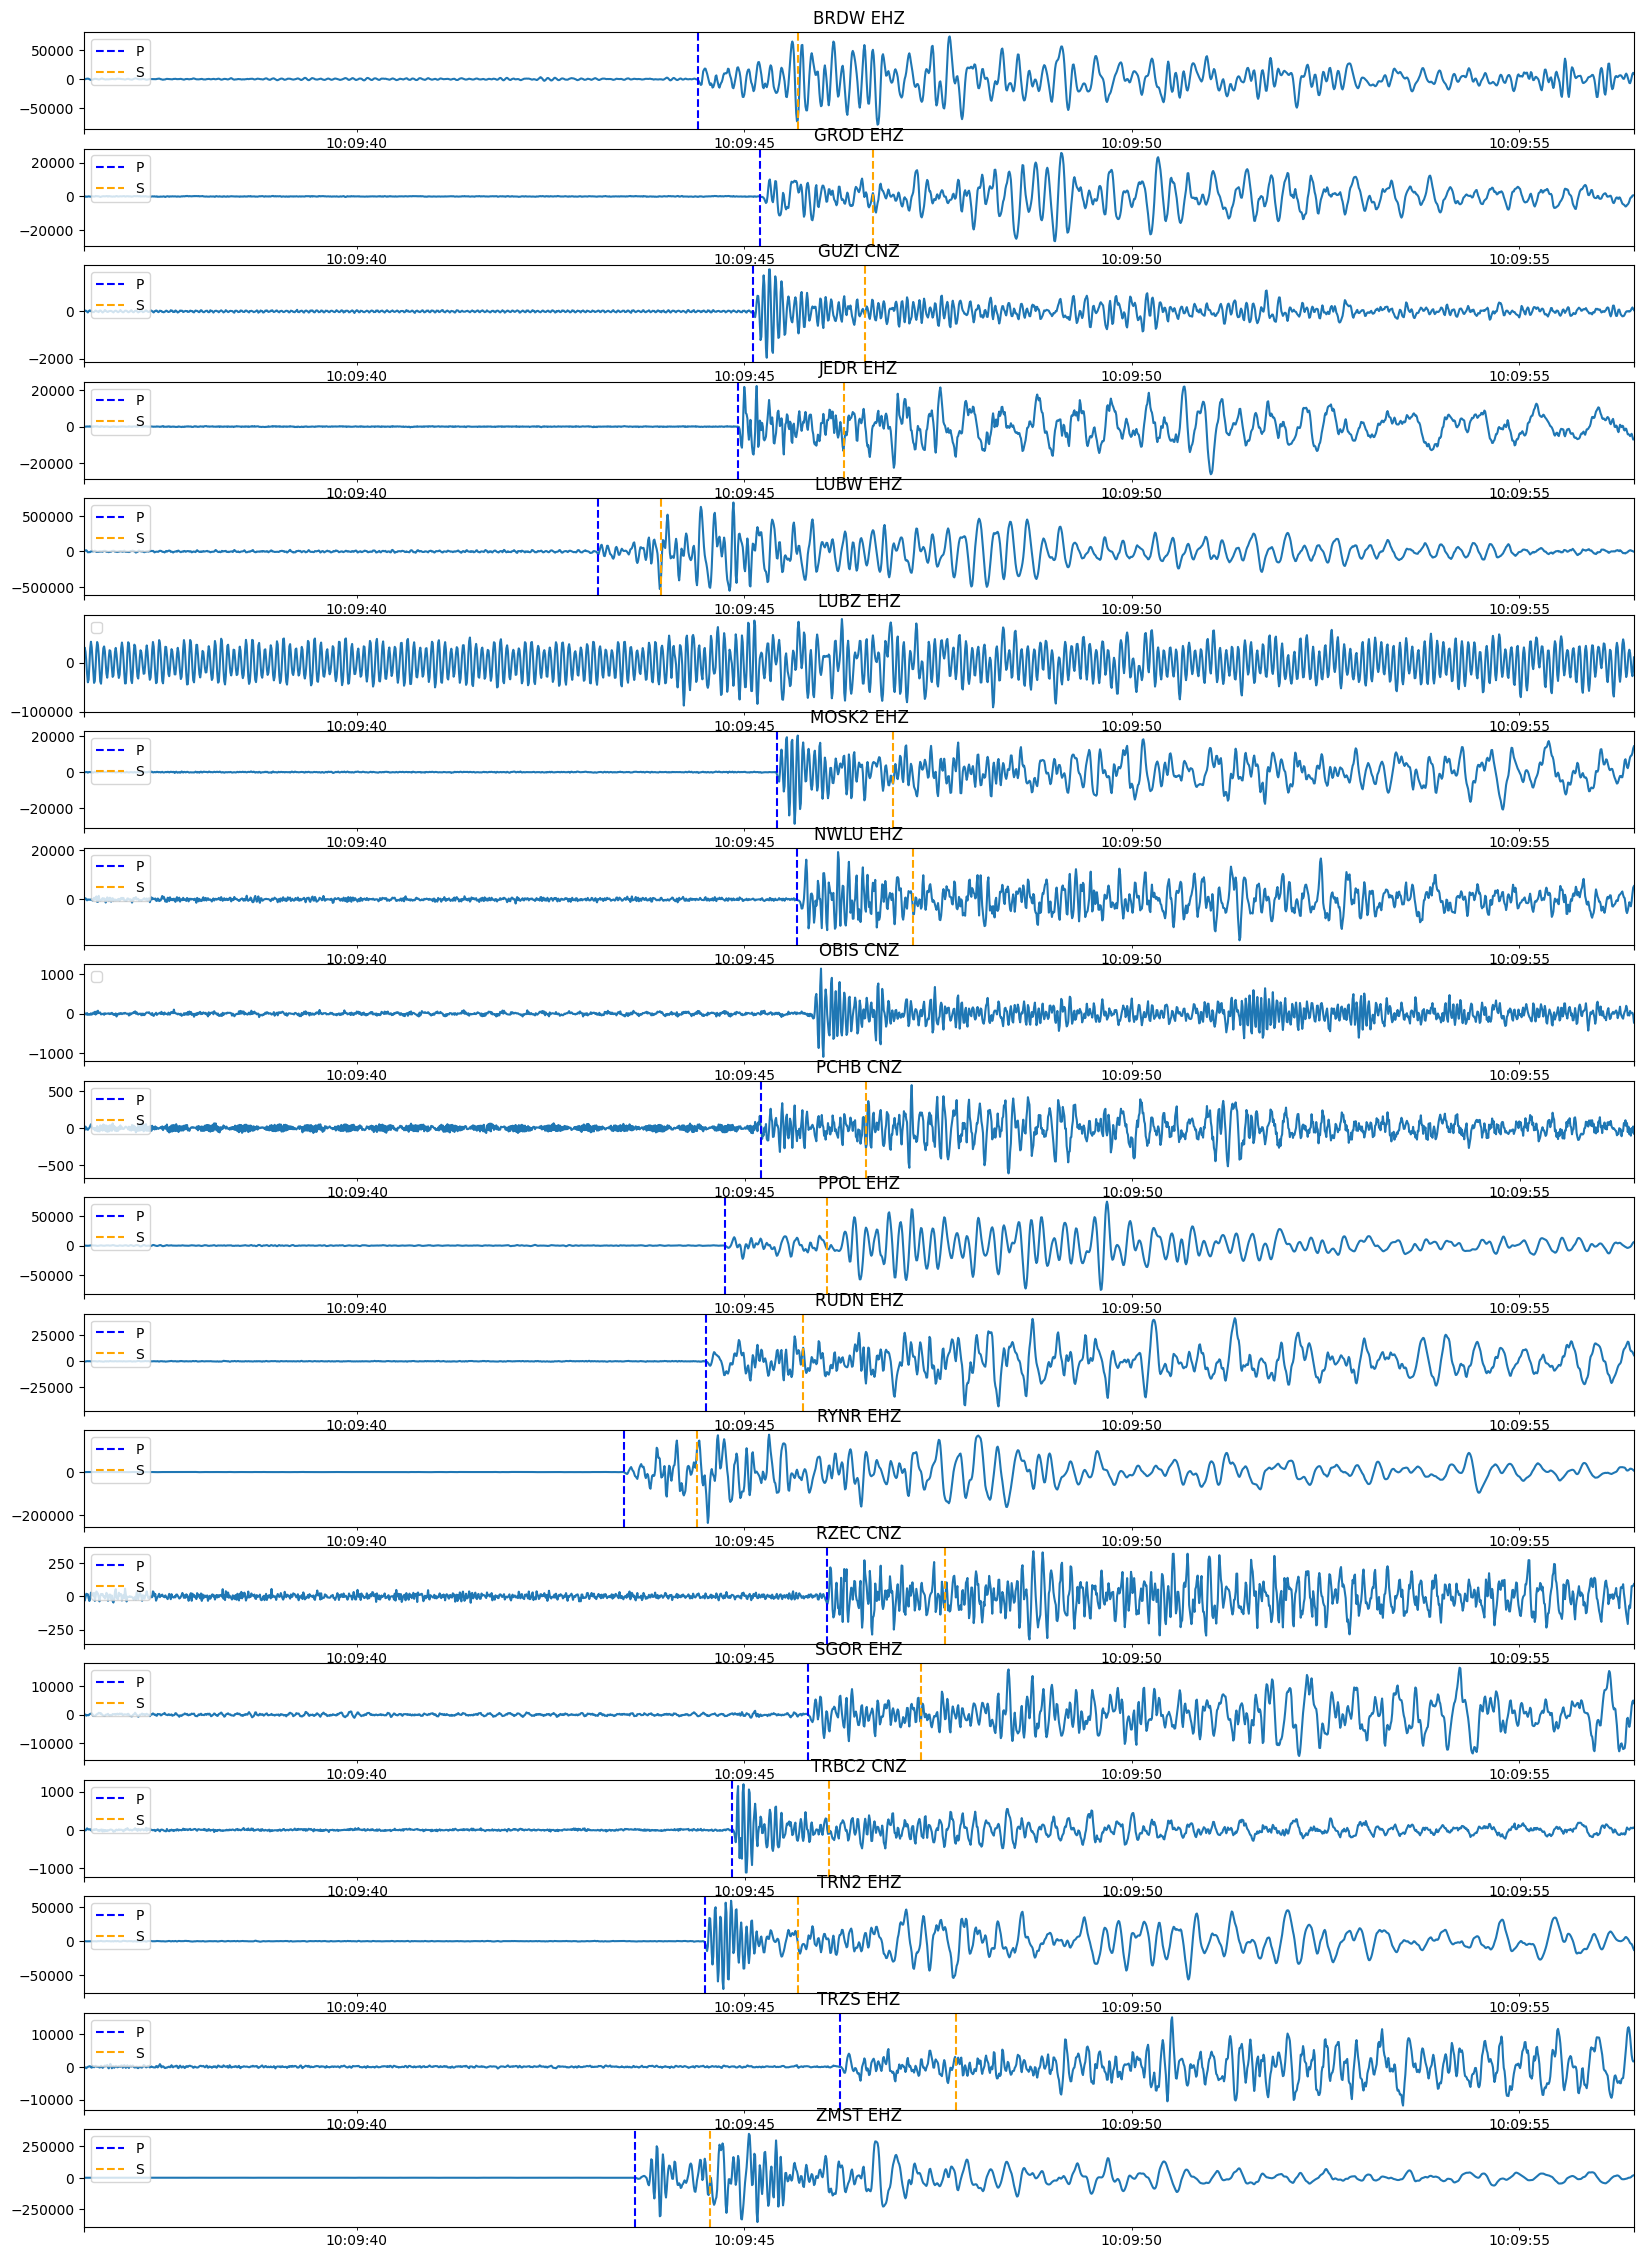

In [17]:
phases = data[data.mseed_name == fname].Phases[0]
plot_traces_from_mseed(phases, fname, channel='Z')

## Plot statistics

### Annotations per station

<Axes: title={'center': 'Phases occurences per station'}>

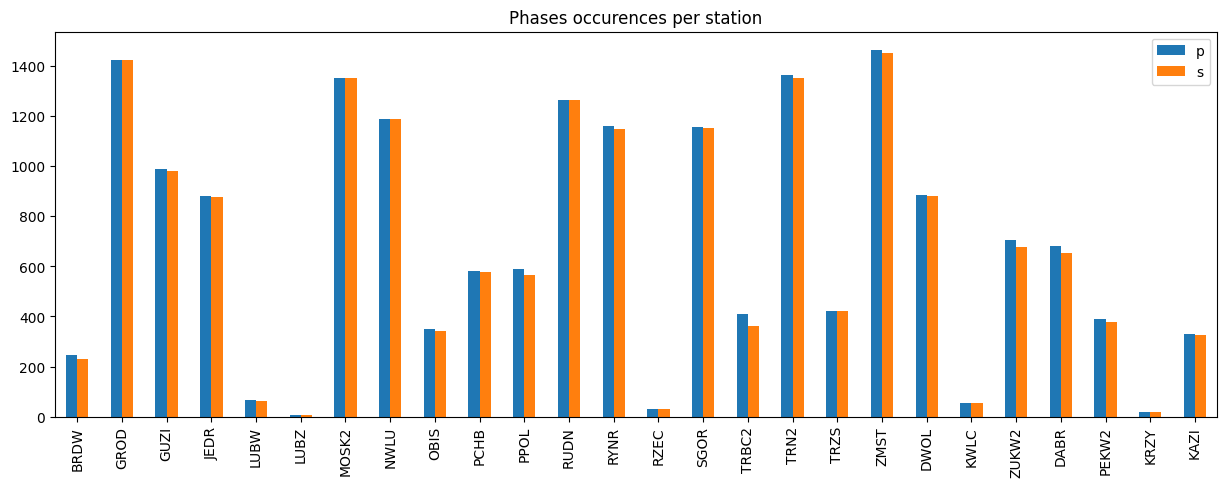

In [18]:
stats.transpose().plot(kind='bar', title = 'Phases occurences per station', figsize=(15,5))

In [19]:
stats.loc['p'].sum()

18002.0

### Missing annotations per station

<Axes: title={'center': 'Missing annotations per station'}>

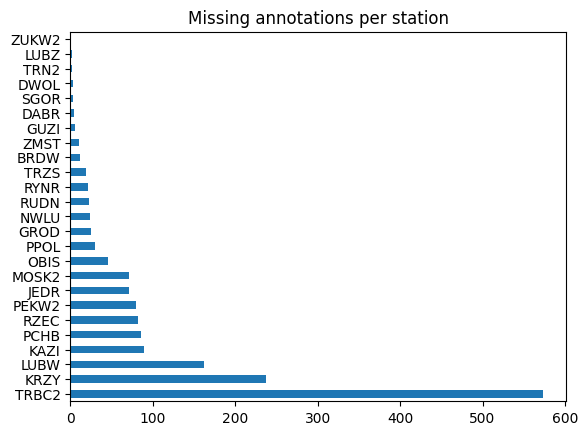

In [20]:
missing_station_list = []
missing_station_list.extend(st[0] if st is not None else None for st in missing_data.stations_with_missing_annotations.values)
pd.Series(missing_station_list).value_counts().plot(kind='barh', title='Missing annotations per station')

### Missing traces per station

<Axes: title={'center': 'Missing traces'}>

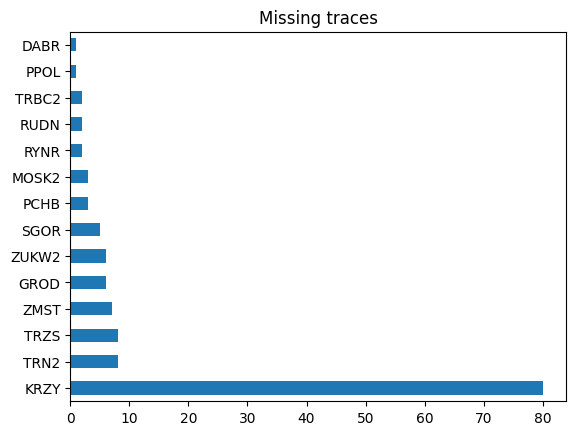

In [21]:
missing_traces_list = []
missing_traces_list.extend(st[0] if st is not None else None for st in missing_data.stations_with_missing_traces.values)
pd.Series(missing_traces_list).value_counts().plot(kind='barh', title='Missing traces')

### Annotations over time

In [22]:
data = pd.merge(data, missing_data, left_on='mseed_name', right_index=True, how='outer')

<Axes: title={'center': 'Cumulative number of traces with Pg annotations'}, xlabel='Datetime'>

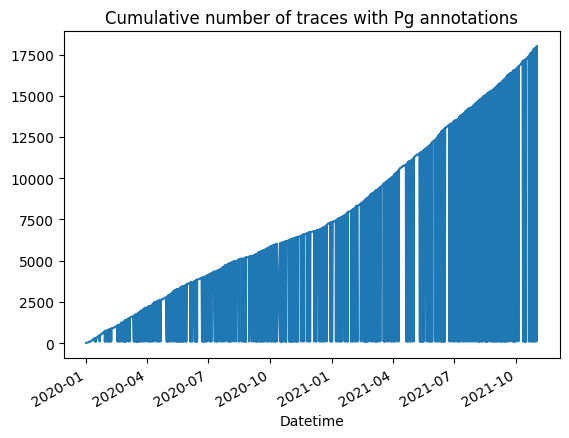

In [23]:
data['Pg_count'] = data.stations_with_available_data.apply(lambda x: len(x) if not pd.isna(x) else 0)
data['Pg_count_cumsum']= data.Pg_count.cumsum()
data.index = data.Datetime
data.Pg_count_cumsum.plot(title="Cumulative number of traces with Pg annotations")

In [24]:
type(data.stations_with_missing_annotations.values[0])

list

In [25]:
data['missing_annotations'] = data.stations_with_missing_annotations.apply(lambda x: len(x) if type(x)==list else 0)
data['missing_traces'] = data.stations_with_missing_traces.apply(lambda x: len(x) if type(x)==list else 0)

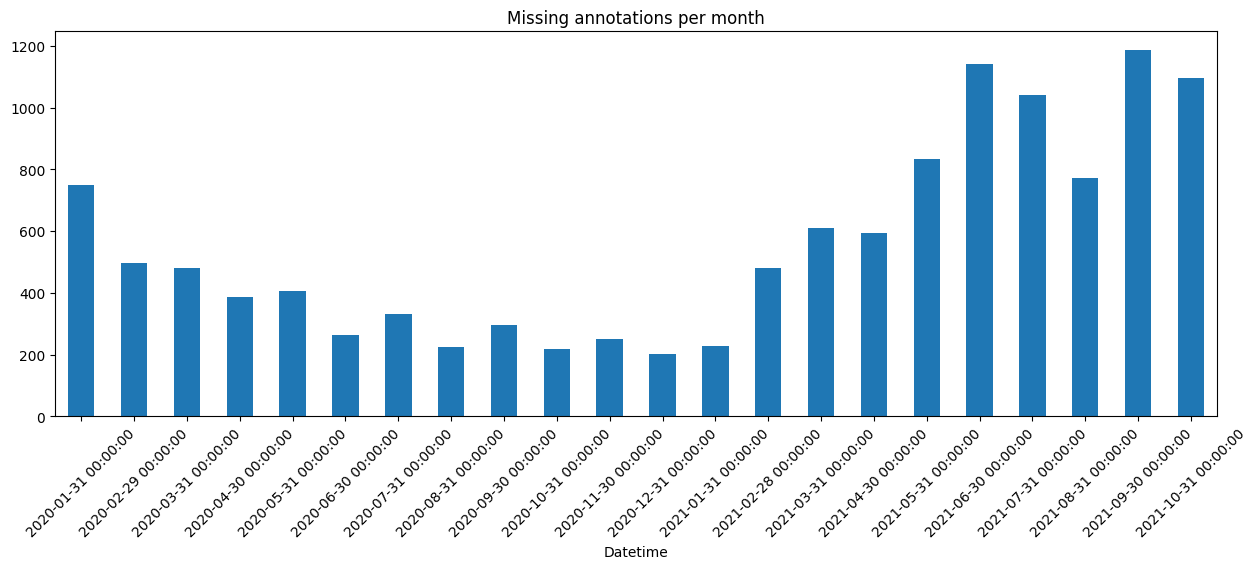

In [26]:

ax = data.groupby([pd.Grouper(key='Datetime', freq='M')])['missing_annotations'].sum().plot(kind='bar', 
                                                                                            title="Missing annotations per month",
                                                                                            rot=45, 
                                                                                           figsize=(15,5))
  


<Axes: title={'center': 'Missing traces in mseeds over time'}, xlabel='Datetime'>

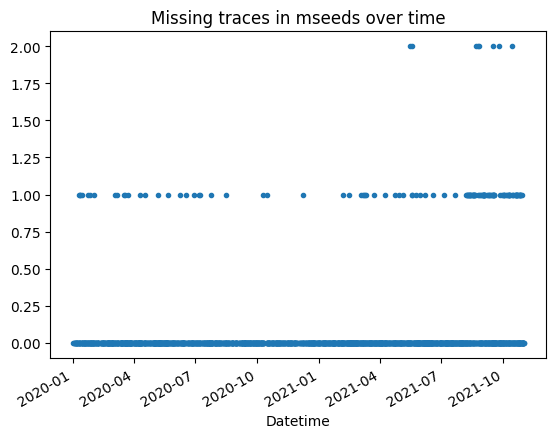

In [27]:
data.missing_traces.plot(marker='.', linestyle='none', title='Missing traces in mseeds over time')

# Plot traces and save figs

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No P annotations for station LUBZ 2020-01-01T10:09:36.480000Z
No S annotations for station LUBZ 2020-01-01T10:09:36.480000Z
No P annotations for station LUBZ 2020-01-01T10:09:36.480000Z
No S annotations for station LUBZ 2020-01-01T10:09:36.480000Z
No P annotations for station LUBZ 2020-01-01T10:09:36.480000Z
No S annotations for station LUBZ 2020-01-01T10:09:36.480000Z


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No P annotations for station OBIS 2020-01-01T10:09:36.478000Z
No S annotations for station OBIS 2020-01-01T10:09:36.478000Z
No P annotations for station OBIS 2020-01-01T10:09:36.476000Z
No S annotations for station OBIS 2020-01-01T10:09:36.476000Z
No P annotations for station OBIS 2020-01-01T10:09:36.480000Z
No S annotations for station OBIS 2020-01-01T10:09:36.480000Z


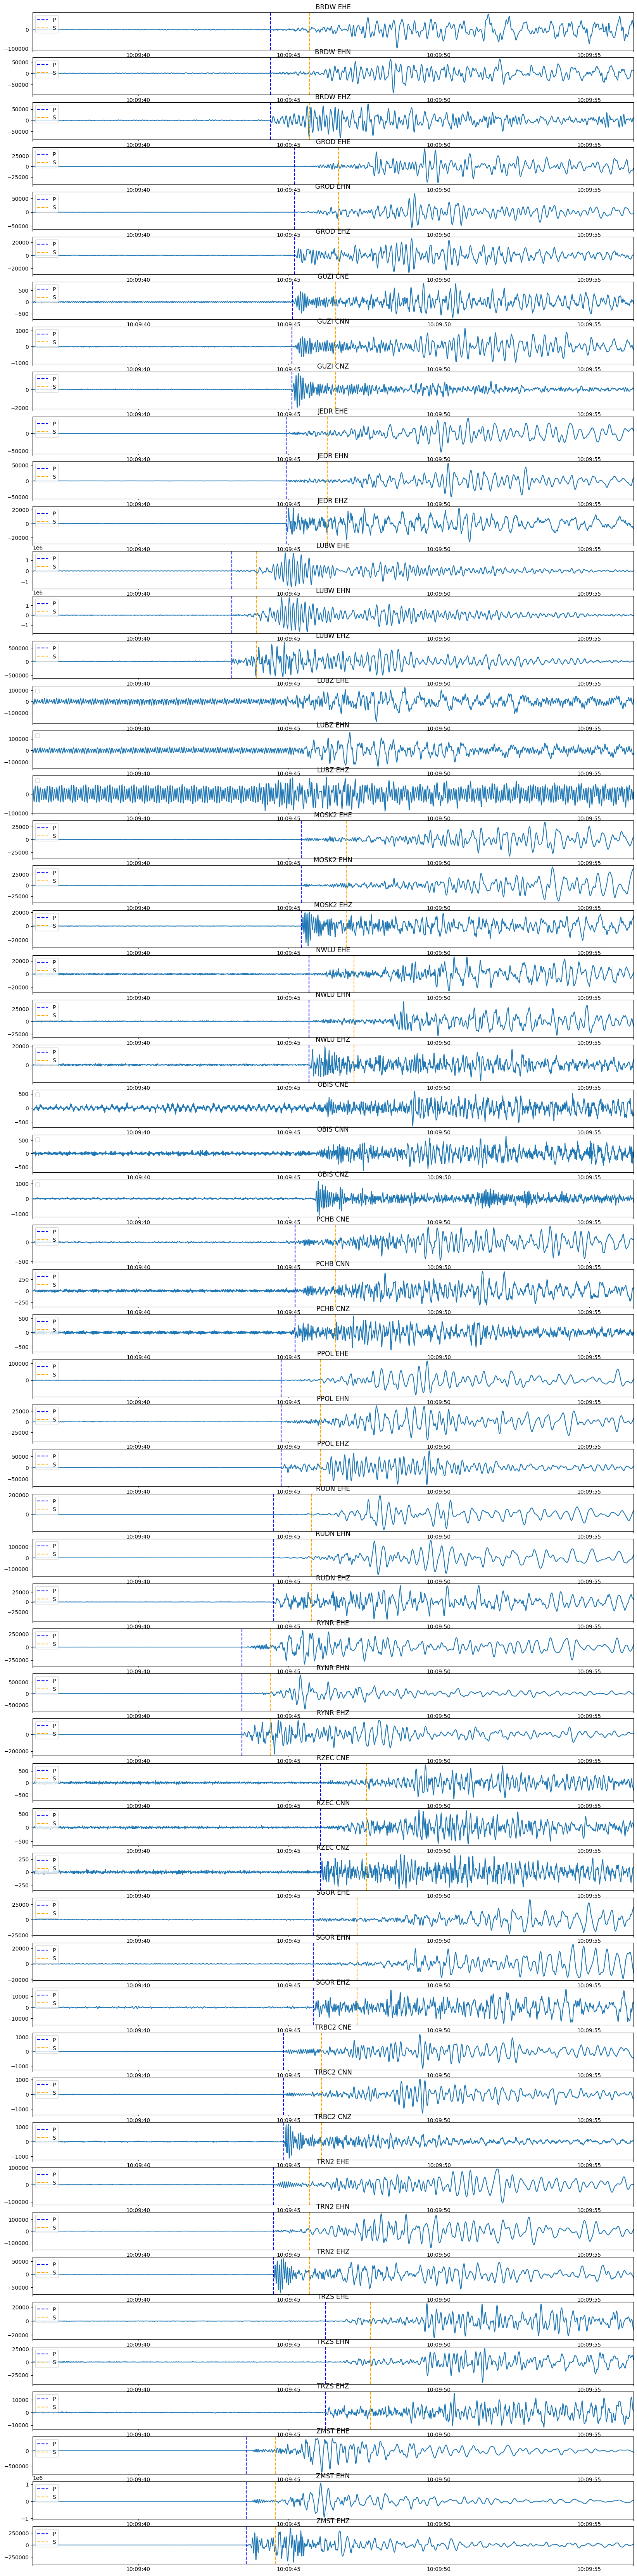

In [28]:

for phases, fname in zip(data.Phases, data.mseed_name): 
    if not pd.isna(fname): 
        plot_traces_from_mseed(phases, fname)
        break
    

In [29]:
with pd.ExcelWriter(data_path+'catalog with missing data.xlsx') as writer:  
    data.to_excel(writer)